In [1]:
import itertools
import numpy as np
from collections import Counter
from typing import List, Dict, Tuple
import time

def evaluate(n: int) -> int:

  capset = solve(n)
  return len(capset), capset

def generate_initial_sequences(n: int) -> np.ndarray:

  bases_cg: List[int] = [1, 2]  
  bases_at: List[int] = [0, 3]  
  all_sequences: List[List[int]] = []

  # Generate sequences with exactly four 1's and 2's
  for cg_positions in itertools.combinations(range(n), 4):
    at_positions = [p for p in range(n) if p not in cg_positions]

    for cg_values in itertools.product(bases_cg, repeat=4):
        for at_values in itertools.product(bases_at, repeat=4):
          sequence = [None] * n
          for pos, val in zip(cg_positions, cg_values):
            sequence[pos] = val
          for pos, val in zip(at_positions, at_values):
            sequence[pos] = val

          all_sequences.append(sequence)
  return np.array(all_sequences, dtype=np.int32)

def solve(n: int) -> np.ndarray:
    all_vectors = generate_initial_sequences(n)
    priorities = np.array([priority(tuple(vector), n) for vector in all_vectors])

    wordset = []
    count=0
    while np.any(priorities != -np.inf):
        max_index = np.argmax(priorities)
        selected_vector = all_vectors[max_index]

        # Vectorized calculation of differences using broadcasting
        differences = np.sum(all_vectors != selected_vector, axis=1)
        mask_complementary = np.array([is_complementary(selected_vector, v) for v in all_vectors])

        # Invalidate vectors that are too similar or not sufficiently complementary
        mask_invalid = (differences < 4) | (~mask_complementary)
        priorities[mask_invalid] = -np.inf
        priorities[max_index] = -np.inf

        wordset.append(selected_vector)

    # Post-collection filtering
    wordset = np.array(wordset)
    print(len(wordset))
    wordset = check_conditions_post(wordset)
    print(len(wordset))
    wordset = check_conditions_post(wordset)
    print(len(wordset))
    return wordset

def is_complementary(seq1, seq2):
    """ Vectorized complement check using einsum and flip. """
    seq1_reversed = np.flip(seq1)
    seq2_complement = wc_complement_vectorized(seq2)
    return np.einsum('i,i->', seq1_reversed != seq2_complement, np.ones_like(seq1_reversed)) >= 4

def wc_complement_vectorized(sequences):
    """ Vectorized Watson-Crick complement calculation. """
    mapping = np.array([3, 2, 1, 0])  # Map of complements
    return mapping[sequences]

def check_conditions_post(wordset: np.ndarray) -> np.ndarray:
    # Check CG count using simple sum over axis
    mask_cg_count = np.array([(np.sum((word == 1) | (word == 2))) == 4 for word in wordset])
    
    # Check for differences between all pairs of words
    n = len(wordset)
    mask_diffs = np.ones(n, dtype=bool)
    for i in range(n):
        for j in range(i + 1, n):
            if np.sum(wordset[i] != wordset[j]) < 4:
                mask_diffs[i] = mask_diffs[j] = False

    # Check for complementarity using vectorized function
    mask_complementary = np.ones(n, dtype=bool)
    for i in range(n):
        for j in range(n):
            if not is_complementary(wordset[i], wordset[j]):
                mask_complementary[i] = False

    # Combine all conditions to form a final mask
    final_mask = mask_cg_count & mask_diffs & mask_complementary
    return wordset[final_mask]


def print_table(wordset: np.ndarray) -> None:
    dna_map = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    sequences = [''.join(dna_map[nuc] for nuc in vector) for vector in wordset]
    
    # Print 4 sequences per row
    for i in range(0, len(sequences), 10):
        print('  '.join(sequences[i:i+10]))


# @funsearch.evolve
def priority(el: Tuple[int, ...], n: int) -> float:
  """
  Returns the priority with which we want to add `element` to the word set.
  
  Args:
  el (Tuple[int, ...]): A tuple representing a DNA sequence, where each element
                        is an integer (0-3 corresponding to A, C, G, T).
  n (int): The length of the DNA sequence (should match the length of `el`).

  Returns:
  float: The calculated priority of the sequence. Higher values indicate higher priority.
  """


  gc_alternating_regions = 0
  for i in range(1, n):
      if (el[i-1] in [1, 3]) != (el[i] in [1, 3]):
          gc_alternating_regions += 1
  diversity_score = len(set(el))
  return (gc_alternating_regions + diversity_score) / n

n=8
d=4

scores = []

l, wordset = evaluate(n)

print(f"number of solutions {l}")
print_table(wordset)



136
120
120
number of solutions 120
CGCGTATA  GCGCATAT  CGTACGTA  GCATGCAT  CACACATG  GTGTGTAC  CACATGCA  GTGTACGT  CATGCACA  GTACGTGT
ACGTGTGT  TGCACACA  CGCGATAT  GCGCTATA  CGTAGCAT  GCATCGTA  CGTAATGC  CACAGTGT  GTGTCACA  CATGGTAC
CATGACGT  GTACTGCA  ACGTTGCA  TACGGCAT  CGGCATTA  GCCGTAAT  CGATGCTA  GCTACGAT  CAGTGTCA  GTCACAGT
CACTACAG  GACATCAC  TCACGACA  ACAGCACT  CGGCTAAT  GCCGATTA  CCGTAACT  GGCATTGA  CCGATTAC  GGCTAATG
CCAGTTGT  GGTCAACA  CGATCGAT  GCTAGCTA  CGATTAGC  CTGGCATT  GACCGTAA  CACCAGTT  GTGGTCAA  CAGTCAAC
GTCAGTTG  CAGTTGGT  GTCAACCA  CAACCAGT  GTTGGTCA  ACGGCTAA  TGCCGATT  ACCAGTCA  TGGTCAGT  ATCGGCTA
CCACAATC  GGTCTTAC  CTGACTGA  GACTGACT  CAACACCA  GTTGTGGT  ACGGTCTT  AGCCACAA  CCAAGGTT  GGTTCCAA
CTCTGATC  GAGACTAG  CTGATCCT  GACTAGGA  CTCAAGAC  CAGAACTC  CTTCGACT  GAAGCTGA  CTAGAGCT  GATCTCGA
TCGACTCT  AGCTGAGA  ACTCCAGA  AGACCTCA  CCTGAAAG  GGAGTTTG  CCAACCAA  CCTTGGAA  GGAACCTT  GGTTGGTT
CTGAGAAG  GACTCTTC  CTCTTCGA  GAGAAGCT  CTAGGAGA  GATCCTCT  CTTCAGGA  GAA

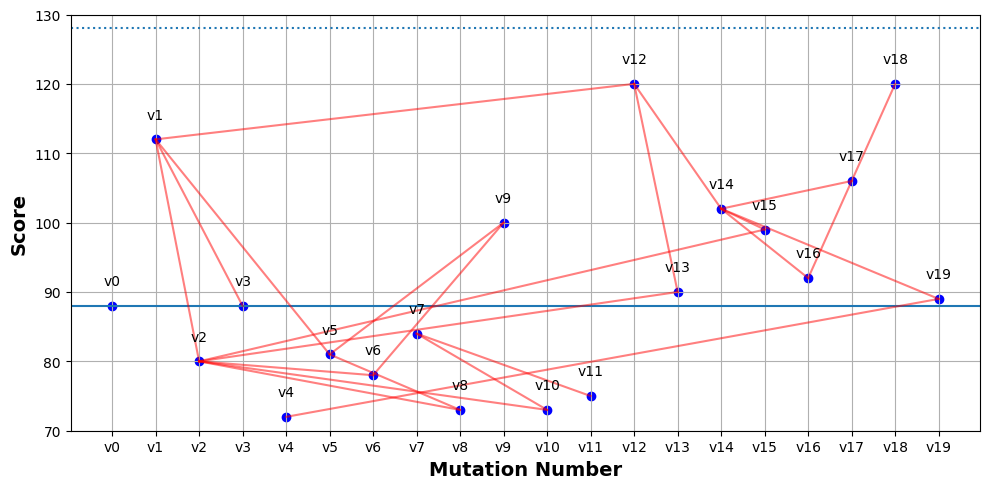

In [15]:
# Creating a scatter plot with connections between versions based on idea lineage
import matplotlib.pyplot as plt
versions= ["v0", "v1", "v2", "v3", "v4", "v5", "v6", "v7", "v8", "v9", "v10", "v11", "v12", "v13", "v14", "v15", "v16", "v17", "v18", "v19"]
scores= [88, 112, 80, 88, 72, 81, 78, 84, 73, 100, 73, 75, 120, 90, 102, 99, 92, 106, 120, 89]

# Node positions based on version and scores
node_x = versions
node_y = scores

# Defining connections (edges) between versions based on table info
edges = [
    (2, 1), (3, 1), (5, 1), (6, 2), (8, 5), (8, 2), (9, 6), (9, 5), (10, 7), (10, 2),
    (11, 7), (12, 1), (13, 12), (13, 2), (14, 12), (15, 14), (15, 2), (16, 14), (17, 14),
    (18, 16), (19, 14), (19, 4)
]

plt.figure(figsize=(10, 5))

# Plotting nodes
plt.scatter(node_x, node_y, color='blue')
plt.axhline(88,label='no priority')
plt.axhline(128,linestyle=':',label='highest set')
# Annotating nodes with version labels
for i, txt in enumerate([f'{i}' for i in versions]):
    plt.annotate(txt, (node_x[i], node_y[i] + 1), textcoords="offset points", xytext=(0,10), ha='center')

# Drawing edges
for edge in edges:
    x = [node_x[edge[0]], node_x[edge[1]]]
    y = [node_y[edge[0]], node_y[edge[1]]]
    plt.plot(x, y, 'r-', alpha=0.5)  # Red lines with 50% transparency

# plt.title('Scatter Plot of Priority Function Scores with Idea Connections')
plt.ylim([70,130])
plt.xlabel('Mutation Number', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig('DNA_word_evolution')
plt.show()
